# Finetune ResNet50


## resnet50_1080silence


With 1920x1080 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'resnet50_1080silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_24208\425797518.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:25<00:00,  2.89it/s, Loss=0.6315932273864746, Elapsed=36.4862s, ETA=0.0000s]  


Epoch 1 completed in 164.0467s
Train Loss: 0.9630507676932164 - Train Accuracy: 58.919970149928766
Validation Loss: 0.8447793785730998 - Validation Accuracy: 64.85859012241451

Epoch 2/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.69it/s, Loss=0.1535378396511078, Elapsed=30.8564s, ETA=0.0000s]  


Epoch 2 completed in 131.6966s
Train Loss: 0.7417410653450586 - Train Accuracy: 68.20289002962393
Validation Loss: 0.8712243219216664 - Validation Accuracy: 64.7002954833263

EarlyStopping counter: 1/5
Epoch 3/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.74it/s, Loss=0.0667446181178093, Elapsed=30.6647s, ETA=0.0000s]  


Epoch 3 completed in 131.5839s
Train Loss: 0.6238692706030917 - Train Accuracy: 73.11910630695823
Validation Loss: 0.7054939280947049 - Validation Accuracy: 71.93963697762769

Epoch 4/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.70it/s, Loss=0.17461811006069183, Elapsed=30.9690s, ETA=0.0000s]  


Epoch 4 completed in 132.4581s
Train Loss: 0.5220498077442192 - Train Accuracy: 76.87524027045973
Validation Loss: 0.7361341355244319 - Validation Accuracy: 74.51456310679612

EarlyStopping counter: 1/5
Epoch 5/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.73it/s, Loss=0.247317835688591, Elapsed=30.6179s, ETA=0.0000s]   


Epoch 5 completed in 131.6896s
Train Loss: 0.4175559541565834 - Train Accuracy: 80.99771601727686
Validation Loss: 0.7434701444705327 - Validation Accuracy: 72.17180244829042

EarlyStopping counter: 2/5
Epoch 6/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.73it/s, Loss=0.4642274081707001, Elapsed=30.7143s, ETA=0.0000s]  


Epoch 6 completed in 132.1536s
Train Loss: 0.3140833601786222 - Train Accuracy: 85.06139616924085
Validation Loss: 0.8641143186887106 - Validation Accuracy: 73.38539468130013

EarlyStopping counter: 3/5
Epoch 7/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.72it/s, Loss=0.10410986095666885, Elapsed=30.8045s, ETA=0.0000s] 


Epoch 7 completed in 131.8558s
Train Loss: 0.2339765474071048 - Train Accuracy: 88.50546120621424
Validation Loss: 1.2888623759150506 - Validation Accuracy: 73.45926551287462

EarlyStopping counter: 4/5
Epoch 8/50


Validating: 100%|██████████| 75/75 [00:20<00:00,  3.58it/s, Loss=0.11796077340841293, Elapsed=31.7562s, ETA=0.0000s] 

Epoch 8 completed in 132.5987s
Train Loss: 0.18874951376649685 - Train Accuracy: 90.84371678614232
Validation Loss: 1.341547426680724 - Validation Accuracy: 69.29084001688476

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


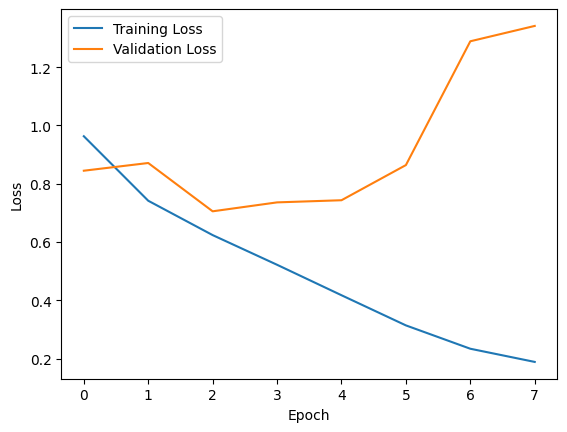

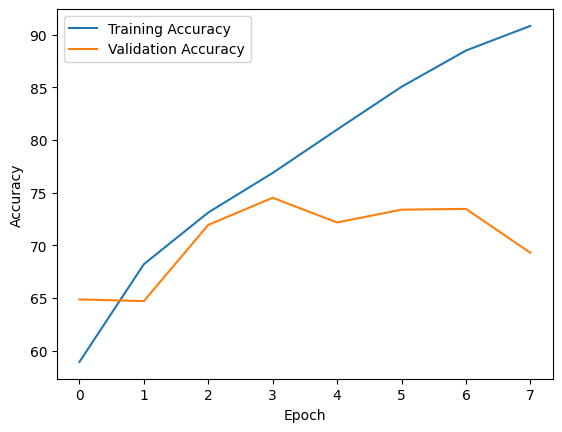

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:37<00:00,  2.01it/s]

Test Accuracy: 0.7327
Test Precision: 0.7450
Test Recall: 0.7327
Test F1-score: 0.7333

              precision    recall  f1-score   support

       Anger       0.64      0.81      0.71       916
       Bored       0.74      0.93      0.83      1098
     Disgust       0.53      0.58      0.55       291
        Fear       0.43      0.70      0.54       308
       Happy       0.76      0.66      0.71      1914
     Neutral       0.72      0.66      0.69      2226
    Question       0.90      0.87      0.88      1139
         Sad       0.83      0.63      0.72       857
    Surprise       0.80      0.72      0.76       728

    accuracy                           0.73      9477
   macro avg       0.71      0.73      0.71      9477
weighted avg       0.74      0.73      0.73      9477



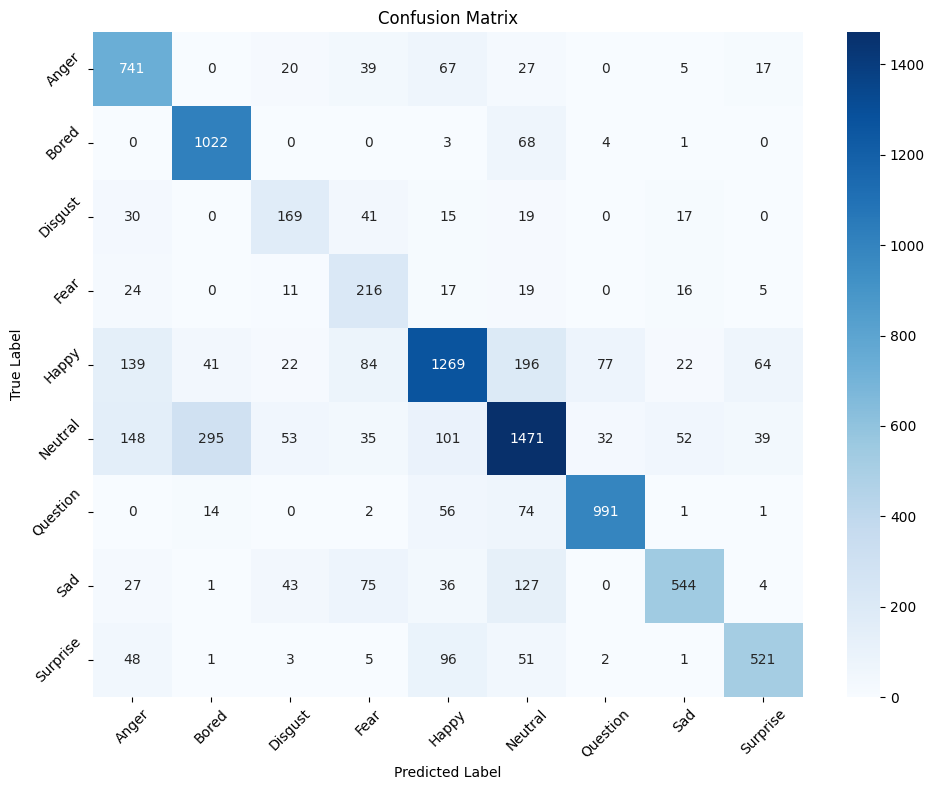

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)